#Seeding for reproducibility

In [1]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [12]:
import os
import json
from zipfile import ZipFile
from PIL import Image # for some preprcessing steps

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # load and display an image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data piplelines
from tensorflow.keras import layers,models

# DATA CURATION

In [5]:
kaggle_credentials= json.load(open("kaggle.json"))

In [6]:
os.environ["KAGGLE_USERNAME"]= kaggle_credentials["username"]
os.environ["KAGGLE_KEY"]=kaggle_credentials["key"]

In [9]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.04G/2.04G [01:53<00:00, 15.4MB/s]
100% 2.04G/2.04G [01:53<00:00, 19.3MB/s]


In [10]:
!ls

kaggle.json  plantvillage-dataset.zip  sample_data


In [13]:
# unziping my dataset

with ZipFile("/content/plantvillage-dataset.zip","r") as zip_ref:
  zip_ref.extractall()

In [14]:
print(os.listdir("plantvillage dataset"))

['color', 'segmented', 'grayscale']


In [18]:
# no of subclasses
print(len(os.listdir("plantvillage dataset/color")))

38


# DATA PREPROCESSING

In [19]:
base_dir="/content/plantvillage dataset/color"

(256, 256, 3)


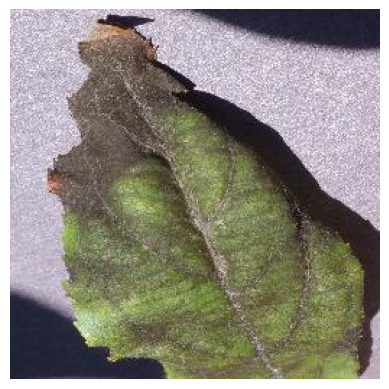

In [24]:
image_path="/content/plantvillage dataset/color/Apple___Apple_scab/0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Scab 3037.JPG"
image=mpimg.imread(image_path)

print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

In [25]:
# ensure all train and test image are of same size

image_size=224
batch_size=32

# TRAIN TEST SPLIT

In [26]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # use 20% of data for validation
)

In [27]:
train_generator= data_gen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)


# directly directory names are given as class labels - data_gen.flow_from_directory

Found 43456 images belonging to 38 classes.


In [28]:
validation_generator= data_gen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)



Found 10849 images belonging to 38 classes.


# CONVOLUTIONAL NEURAL NETWORK

In [32]:
model=models.Sequential()


model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)              

In [34]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5
1358/1358 [==============================] - 119s 83ms/step - loss: 0.9770 - accuracy: 0.7332 - val_loss: 0.5017 - val_accuracy: 0.8414
Epoch 2/5
1358/1358 [==============================] - 114s 84ms/step - loss: 0.2816 - accuracy: 0.9091 - val_loss: 0.4632 - val_accuracy: 0.8562
Epoch 3/5
1358/1358 [==============================] - 112s 82ms/step - loss: 0.1342 - accuracy: 0.9567 - val_loss: 0.4356 - val_accuracy: 0.8789
Epoch 4/5
1358/1358 [==============================] - 111s 81ms/step - loss: 0.0878 - accuracy: 0.9714 - val_loss: 0.5119 - val_accuracy: 0.8763
Epoch 5/5
1358/1358 [==============================] - 111s 82ms/step - loss: 0.0641 - accuracy: 0.9786 - val_loss: 0.6499 - val_accuracy: 0.8569


In [36]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 [==============================] - 19s 55ms/step - loss: 0.6499 - accuracy: 0.8569
Validation Accuracy: 85.69%


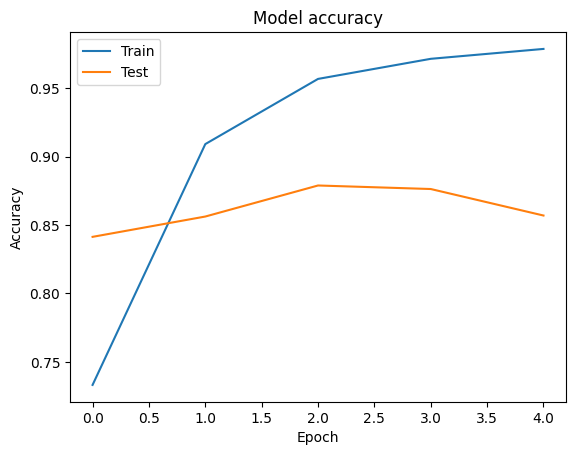

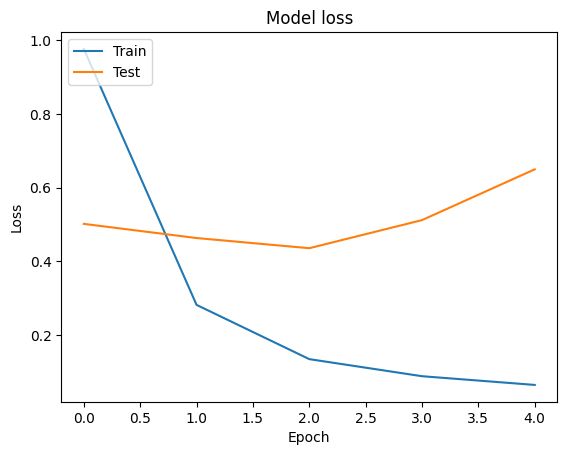

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Building a Predictive System

In [38]:
image_path="/content/plantvillage dataset/color/Apple___Apple_scab/0812e1e4-6d1b-4264-8f23-6519354fc5a6___FREC_Scab 3293.JPG"

In [39]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


In [40]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [42]:
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 271ms/step
Predicted Class Name: Apple___Apple_scab
